In [1]:
# Modules
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import datetime
import os

# Functions
from implementations_cross_validation import *
from helpers import *
from preprocessing import *

# Autoreload
%load_ext autoreload
%autoreload 2


In [2]:
# Set random seed
np.random.seed(0)

(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_, labels = process_data(data_raw, t_data_raw, labels_raw,
                                      ids_raw, sample_filtering = False, feature_filtering = False,
                                      replace = 'median', remove_outlier=True)


The original dimensions of the training data set was 250000 samples and 30 columns
 After feature and sample filtering, there are 250000 samples and 30 columns


In [3]:
# Create train/test split

X_train, y_train, X_test, y_test = split_data(data_, labels, ratio=0.8, seed=0)

# Add interaction terms and polynomial of degree 2 to cross val set (no bias term is added here
# since its done inside crossval function)

X_train_int = build_interact_terms(X_train)
X_test_int = build_interact_terms(X_test)
X_train_poly = build_poly(X_train, 2)
X_test_poly = build_poly(X_test, 2)
X_train = np.c_[X_train_poly, X_train_int]
X_test_forstd = np.c_[X_test_poly, X_test_int]

# Create standardizations for the split
X_train_std, mean, variance = standardize(X_train)
X_test_std = standardize_test(X_test_forstd, mean, variance)


# Perform PCA
eigVal, eigVec, sumEigVal = PCA(X_train_std, threshold = 0.9)
X_train_std = X_train_std.dot(eigVec)
X_test_std = X_test_std.dot(eigVec)

# Add the bias term for the final models
y_train, X_train_std = build_model_data(X_train_std, y_train)
y_test, X_test_std = build_model_data(X_test_std, y_test)


# Initialize boxplots values
boxplots = []
test_accuracies = []

# Linear Regression: Gradient Descent

In [4]:
# Initialize w vector
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6

# Perform linear regression by gradient descent with cross validation (k=4)
test_loss_mean, test_loss_var, vector_test_loss, train_loss_mean, w_final, accuracies = least_squares_GD(y_train, X_train, initial_w, gamma = 0.005, k=k_, max_iters = 500)
boxplots.append(accuracies)

# Perform linear regression by gradient descent on whole training set
w = least_squares_GD(y_train, X_train_std, initial_w, gamma = 0.005, k=0, max_iters = 500)

# Use w to predict unseen test set labels
test_pred_lab = predict_labels(w, X_test_std)
test_accuracy = pred_accuracy(test_pred_lab, y_test)
test_accuracies.append(test_accuracy)

In [6]:
# Write results to file

file_object = open('cv_results', 'w')
file_object.write('fold1, fold2, fold3, fold4, test_set \n')
acc_s = str(accuracies[0]) + ', ' + str(accuracies[1]) + ', ' + str(accuracies[2]) + ', ' + str(accuracies[3])
acc_t = str(test_accuracy) + '\n'
file_object.write(acc_s + ', ' + acc_t)


88

# Linear Regression: Stochastic Gradient Descent

In [7]:
# Initialize w vector
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6

# Perform algorithm with cross validation (k=4)
w_final, accuracies = least_squares_SGD(y_train, X_train, initial_w, batch_size=400, gamma = 0.005, k=k_, max_iters=500)
boxplots.append(accuracies)

# Perform algorithm on whole training set
w = least_squares_SGD(y_train, X_train_std, initial_w, gamma = 0.005, batch_size = 1000, k=0, max_iters=500)

# Use w to predict unseen test set labels
test_pred_lab = predict_labels(w, X_test_std)
test_accuracy = pred_accuracy(test_pred_lab, y_test)
test_accuracies.append(test_accuracy)

In [9]:
# Write results to file

acc_s = str(accuracies[0]) + ', ' + str(accuracies[1]) + ', ' + str(accuracies[2]) + ', ' + str(accuracies[3])
acc_t = str(test_accuracy) + '\n'
file_object.write(acc_s + ', ' + acc_t)

88

# Linear Regression: Direct Least Squares

In [10]:
k_ = 6

# Perform linear regression by direct least squares with cross validation (k=4)
test_loss_mean, test_loss_var, train_loss_mean, w_final, accuracies = least_squares(y_train, X_train, k_)
boxplots.append(accuracies)

# Perform linear regression by direct least squares on whole training set
w = least_squares(y_train, X_train_std, k=0)

# Use w to predict unseen test set labels
test_pred_lab = predict_labels(w, X_test_std)
test_accuracy = pred_accuracy(test_pred_lab, y_test)
test_accuracies.append(test_accuracy)

In [11]:
# Write results to file

acc_s = str(accuracies[0]) + ', ' + str(accuracies[1]) + ', ' + str(accuracies[2]) + ', ' + str(accuracies[3])
acc_t = str(test_accuracy) + '\n'
file_object.write(acc_s + ', ' + acc_t)


87

# Linear Regression: Regularized

In [12]:
# Search for optimal lambda value to implement for cross validation

lambdas = np.logspace(-7, 0, 30)
rmse_tr = []
rmse_ts = []
pred_tr = []
pred_ts = []

for ind, lambda_ in enumerate(lambdas):
    
    w = ridge_regression(y_train, X_train_std, lambda_, k=0)
    
#     rmse_tr.append(np.sqrt(2 * compute_loss(y_train, X_train, w)))
    pred_tr.append(pred_accuracy(predict_labels(w, X_train_std), y_train))
#     rmse_ts.append(np.sqrt(2 * compute_loss(y_test, X_test, w)))
    pred_ts.append(pred_accuracy(predict_labels(w, X_test_std), y_test))
    
selected_lambda = lambdas[np.argmax(pred_ts)]

In [13]:
print(selected_lambda)

0.06210169418915616


In [14]:
k_ = 6

# Perform regularized linear regression with cross validation (k=4)
# Note that the value for lambda that is selected for this cross validation assessment it taken 
# from the above grid search which provided the best accuracies scores for the test set.

w_final, accuracies = ridge_regression(y_train, X_train, lambda_=selected_lambda, k=k_)
boxplots.append(accuracies)

# Perform regularized linear regression on whole training set
w = ridge_regression(y_train, X_train_std, lambda_=selected_lambda, k=0)

# Use w to predict unseen test set labels
test_pred_lab = predict_labels(w, X_test_std)
test_accuracy = pred_accuracy(test_pred_lab, y_test)
test_accuracies.append(test_accuracy)

In [15]:
# Write results to file

acc_s = str(accuracies[0]) + ', ' + str(accuracies[1]) + ', ' + str(accuracies[2]) + ', ' + str(accuracies[3])
acc_t = str(test_accuracy) + '\n'
file_object.write(acc_s + ', ' + acc_t)

88

# Logistic Regression

In [16]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

gen = cross_val(y_train, X_train, k_) # initiate generator object
accuracies = []
for i in np.arange(k_):
    y_tr, x_tr, y_te, x_te = next(gen) # take next subtraining and subtest sets
    w = np.random.rand(x_tr.shape[1])
    losses, losses_t, acc, acc_t, w = logistic_hessian(y_tr, x_tr, y_te, x_te, w, 0.07, 500, 150, writing=False)
    accuracies.append(acc_t[-1])
boxplots.append(accuracies)

# Perform algorithm on entire training set to retrieve w
losses, losses_t, acc, test_accuracy, w = logistic_hessian(y_train, X_train_std, y_test,
                                                           X_test_std, initial_w, 0.07, 500, 150, writing=False)
test_accuracies.append(test_accuracy[-1])

In [17]:
# Write results to file

acc_s = str(accuracies[0]) + ', ' + str(accuracies[1]) + ', ' + str(accuracies[2]) + ', ' + str(accuracies[3])
acc_t = str(test_accuracy) + '\n'
file_object.write(acc_s + ', ' + acc_t)
file_object.close()

# Create Boxplots

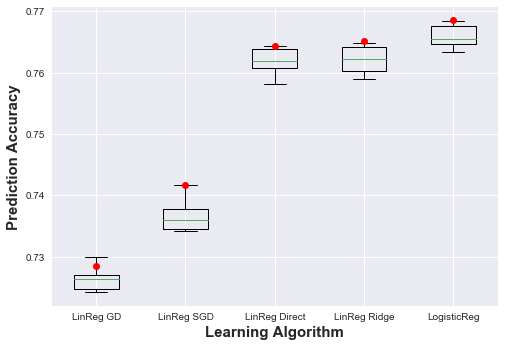

In [42]:
# Create boxplots
plt.style.use('seaborn')
plt.boxplot(boxplots, labels=['LinReg GD', 'LinReg SGD','LinReg Direct','LinReg Ridge','LogisticReg'])
plt.xlabel('Learning Algorithm', weight='bold', fontsize=15)
plt.ylabel('Prediction Accuracy', weight='bold', fontsize=15)
plt.plot(1, test_accuracies[0], marker='o', c='red')
plt.plot(2, test_accuracies[1], marker='o', c='red')
plt.plot(3, test_accuracies[2], marker='o', c='red')
plt.plot(4, test_accuracies[3], marker='o', c='red')
plt.plot(5, test_accuracies[4], marker='o', c='red')
plt.savefig('LearningAlgs.png')
# print(test_accuracies)

# Logistic Regression with Varying Degrees and Interaction Terms

**Without addition of features by degree 2 or interaction terms or**

In [30]:
# Create train/test split

X_train, y_train, X_test, y_test = split_data(data_, labels, ratio=0.8, seed=0)

# Create standardizations for the split
X_train_std, mean, variance = standardize(X_train)
X_test_std = standardize_test(X_test, mean, variance)


# Perform PCA
eigVal, eigVec, sumEigVal = PCA(X_train_std, threshold = 0.9)
X_train_std = X_train_std.dot(eigVec)
X_test_std = X_test_std.dot(eigVec)

# Add the bias term for the final models
y_train, X_train_std = build_model_data(X_train_std, y_train)
y_test, X_test_std = build_model_data(X_test_std, y_test)


# Initialize boxplots values
boxplots_log = []
test_accuracies_log = []

In [31]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

gen = cross_val(y_train, X_train, k_) # initiate generator object
accuracies = []
for i in np.arange(k_):
    y_tr, x_tr, y_te, x_te = next(gen) # take next subtraining and subtest sets
    w = np.random.rand(x_tr.shape[1])
    losses, losses_t, acc, acc_t, w = logistic_hessian(y_tr, x_tr, y_te, x_te, w, 0.07, 500, 150, writing=False)
    accuracies.append(acc_t[-1])
boxplots_log.append(accuracies)

# Perform algorithm on entire training set to retrieve w
losses, losses_t, acc, test_accuracy, w = logistic_hessian(y_train, X_train_std, y_test,
                                                           X_test_std, initial_w, 0.07, 500, 150, writing=False)
test_accuracies_log.append(test_accuracy[-1])

**With degree 2 without interaction terms**

In [32]:
# Create train/test split

X_train, y_train, X_test, y_test = split_data(data_, labels, ratio=0.8, seed=0)

X_train = build_poly(X_train, 2)
X_test = build_poly(X_test, 2)

# Create standardizations for the split
X_train_std, mean, variance = standardize(X_train)
X_test_std = standardize_test(X_test, mean, variance)

# Perform PCA
eigVal, eigVec, sumEigVal = PCA(X_train_std, threshold = 0.9)
X_train_std = X_train_std.dot(eigVec)
X_test_std = X_test_std.dot(eigVec)

# Add the bias term for the final models
y_train, X_train_std = build_model_data(X_train_std, y_train)
y_test, X_test_std = build_model_data(X_test_std, y_test)


In [33]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

gen = cross_val(y_train, X_train, k_) # initiate generator object
accuracies = []
for i in np.arange(k_):
    y_tr, x_tr, y_te, x_te = next(gen) # take next subtraining and subtest sets
    w = np.random.rand(x_tr.shape[1])
    losses, losses_t, acc, acc_t, w = logistic_hessian(y_tr, x_tr, y_te, x_te, w, 0.07, 500, 150, writing=False)
    accuracies.append(acc_t[-1])
boxplots_log.append(accuracies)

# Perform algorithm on entire training set to retrieve w
losses, losses_t, acc, test_accuracy, w = logistic_hessian(y_train, X_train_std, y_test,
                                                           X_test_std, initial_w, 0.07, 500, 150, writing=False)
test_accuracies_log.append(test_accuracy[-1])

**With degree 3 without interaction terms**

In [34]:
# Create train/test split

X_train, y_train, X_test, y_test = split_data(data_, labels, ratio=0.8, seed=0)

X_train = build_poly(X_train, 3)
X_test = build_poly(X_test, 3)

# Create standardizations for the split
X_train_std, mean, variance = standardize(X_train)
X_test_std = standardize_test(X_test, mean, variance)

# Perform PCA
eigVal, eigVec, sumEigVal = PCA(X_train_std, threshold = 0.9)
X_train_std = X_train_std.dot(eigVec)
X_test_std = X_test_std.dot(eigVec)

# Add the bias term for the final models
y_train, X_train_std = build_model_data(X_train_std, y_train)
y_test, X_test_std = build_model_data(X_test_std, y_test)


In [35]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

gen = cross_val(y_train, X_train, k_) # initiate generator object
accuracies = []
for i in np.arange(k_):
    y_tr, x_tr, y_te, x_te = next(gen) # take next subtraining and subtest sets
    w = np.random.rand(x_tr.shape[1])
    losses, losses_t, acc, acc_t, w = logistic_hessian(y_tr, x_tr, y_te, x_te, w, 0.07, 500, 150, writing=False)
    accuracies.append(acc_t[-1])
boxplots_log.append(accuracies)

# Perform algorithm on entire training set to retrieve w
losses, losses_t, acc, test_accuracy, w = logistic_hessian(y_train, X_train_std, y_test,
                                                           X_test_std, initial_w, 0.07, 500, 150, writing=False)
test_accuracies_log.append(test_accuracy[-1])

**With degree 2 and interaction terms**

In [36]:
# Create train/test split

X_train, y_train, X_test, y_test = split_data(data_, labels, ratio=0.8, seed=0)

# Add interaction terms and polynomial of degree 2 to cross val set (no bias term is added here
# since its done inside crossval function)

X_train_int = build_interact_terms(X_train)
X_test_int = build_interact_terms(X_test)
X_train_poly = build_poly(X_train, 2)
X_test_poly = build_poly(X_test, 2)
X_train = np.c_[X_train_poly, X_train_int]
X_test_forstd = np.c_[X_test_poly, X_test_int]

# Create standardizations for the split
X_train_std, mean, variance = standardize(X_train)
X_test_std = standardize_test(X_test_forstd, mean, variance)


# Perform PCA
eigVal, eigVec, sumEigVal = PCA(X_train_std, threshold = 0.9)
X_train_std = X_train_std.dot(eigVec)
X_test_std = X_test_std.dot(eigVec)

# Add the bias term for the final models
y_train, X_train_std = build_model_data(X_train_std, y_train)
y_test, X_test_std = build_model_data(X_test_std, y_test)


In [37]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

gen = cross_val(y_train, X_train, k_) # initiate generator object
accuracies = []
for i in np.arange(k_):
    y_tr, x_tr, y_te, x_te = next(gen) # take next subtraining and subtest sets
    w = np.random.rand(x_tr.shape[1])
    losses, losses_t, acc, acc_t, w = logistic_hessian(y_tr, x_tr, y_te, x_te, w, 0.07, 500, 150, writing=False)
    accuracies.append(acc_t[-1])
boxplots_log.append(accuracies)

# Perform algorithm on entire training set to retrieve w
losses, losses_t, acc, test_accuracy, w = logistic_hessian(y_train, X_train_std, y_test,
                                                           X_test_std, initial_w, 0.07, 500, 150, writing=False)
test_accuracies_log.append(test_accuracy[-1])

**With degree 3 and interaction terms**

In [38]:
# Create train/test split

X_train, y_train, X_test, y_test = split_data(data_, labels, ratio=0.8, seed=0)

# Add interaction terms and polynomial of degree 2 to cross val set (no bias term is added here
# since its done inside crossval function)

X_train_int = build_interact_terms(X_train)
X_test_int = build_interact_terms(X_test)
X_train_poly = build_poly(X_train, 3)
X_test_poly = build_poly(X_test, 3)
X_train = np.c_[X_train_poly, X_train_int]
X_test_forstd = np.c_[X_test_poly, X_test_int]

# Create standardizations for the split
X_train_std, mean, variance = standardize(X_train)
X_test_std = standardize_test(X_test_forstd, mean, variance)


# Perform PCA
eigVal, eigVec, sumEigVal = PCA(X_train_std, threshold = 0.9)
X_train_std = X_train_std.dot(eigVec)
X_test_std = X_test_std.dot(eigVec)

# Add the bias term for the final models
y_train, X_train_std = build_model_data(X_train_std, y_train)
y_test, X_test_std = build_model_data(X_test_std, y_test)

In [39]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

gen = cross_val(y_train, X_train, k_) # initiate generator object
accuracies = []
for i in np.arange(k_):
    y_tr, x_tr, y_te, x_te = next(gen) # take next subtraining and subtest sets
    w = np.random.rand(x_tr.shape[1])
    losses, losses_t, acc, acc_t, w = logistic_hessian(y_tr, x_tr, y_te, x_te, w, 0.07, 500, 150, writing=False)
    accuracies.append(acc_t[-1])
boxplots_log.append(accuracies)

# Perform algorithm on entire training set to retrieve w
losses, losses_t, acc, test_accuracy, w = logistic_hessian(y_train, X_train_std, y_test,
                                                           X_test_std, initial_w, 0.07, 500, 150, writing=False)
test_accuracies_log.append(test_accuracy[-1])

# Create Boxplots

5


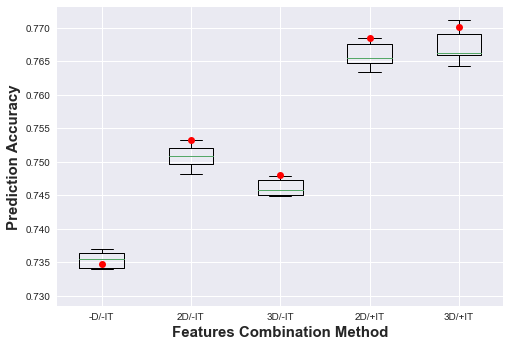

In [41]:
# Create boxplots
print(len(boxplots_log))
plt.style.use('seaborn')
plt.boxplot(boxplots_log, labels=['-D/-IT', '2D/-IT','3D/-IT','2D/+IT','3D/+IT'])
# plt.boxplot(boxplots, labels=[''])
plt.xlabel('Features Combination Method', weight='bold', fontsize=15)
plt.ylabel('Prediction Accuracy', weight='bold', fontsize=15)
plt.plot(1, test_accuracies_log[0], marker='o', c='red')
plt.plot(2, test_accuracies_log[1], marker='o', c='red')
plt.plot(3, test_accuracies_log[2], marker='o', c='red')
plt.plot(4, test_accuracies_log[3], marker='o', c='red')
plt.plot(5, test_accuracies_log[4], marker='o', c='red')
plt.savefig('FeatureExpansion.png')

# Testing Different Preprocessing Methods

**With sample and feature filtering. Replace by Mean**

In [43]:
# Set random seed
np.random.seed(0)

(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_, labels = process_data(data_raw, t_data_raw, labels_raw,
                                      ids_raw, sample_filtering = True, feature_filtering = True,
                                      replace = 'mean', remove_outlier=False)

# Create train/test split

X_train, y_train, X_test, y_test = split_data(data_, labels, ratio=0.8, seed=0)

# Add interaction terms and polynomial of degree 2 to cross val set (no bias term is added here
# since its done inside crossval function)

X_train_int = build_interact_terms(X_train)
X_test_int = build_interact_terms(X_test)
X_train_poly = build_poly(X_train, 3)
X_test_poly = build_poly(X_test, 3)
X_train = np.c_[X_train_poly, X_train_int]
X_test_forstd = np.c_[X_test_poly, X_test_int]

# Create standardizations for the split
X_train_std, mean, variance = standardize(X_train)
X_test_std = standardize_test(X_test_forstd, mean, variance)


# Perform PCA
eigVal, eigVec, sumEigVal = PCA(X_train_std, threshold = 0.9)
X_train_std = X_train_std.dot(eigVec)
X_test_std = X_test_std.dot(eigVec)

# Add the bias term for the final models
y_train, X_train_std = build_model_data(X_train_std, y_train)
y_test, X_test_std = build_model_data(X_test_std, y_test)

boxplots_preprocessing = []
test_accuracies_preprocessing = []

The original dimensions of the training data set was 250000 samples and 30 columns
 After feature and sample filtering, there are 223877 samples and 23 columns


In [44]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

gen = cross_val(y_train, X_train, k_) # initiate generator object
accuracies = []
for i in np.arange(k_):
    y_tr, x_tr, y_te, x_te = next(gen) # take next subtraining and subtest sets
    w = np.random.rand(x_tr.shape[1])
    losses, losses_t, acc, acc_t, w = logistic_hessian(y_tr, x_tr, y_te, x_te, w, 0.07, 500, 150, writing=False)
    accuracies.append(acc_t[-1])
boxplots_preprocessing.append(accuracies)

# Perform algorithm on entire training set to retrieve w
losses, losses_t, acc, test_accuracy, w = logistic_hessian(y_train, X_train_std, y_test,
                                                           X_test_std, initial_w, 0.07, 500, 150, writing=False)
test_accuracies_preprocessing.append(test_accuracy[-1])

**With sample and feature filtering. Replace by median**

In [45]:
# Set random seed
np.random.seed(0)

(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_, labels = process_data(data_raw, t_data_raw, labels_raw,
                                      ids_raw, sample_filtering = True, feature_filtering = True,
                                      replace = 'median', remove_outlier=False)

# Create train/test split

X_train, y_train, X_test, y_test = split_data(data_, labels, ratio=0.8, seed=0)

# Add interaction terms and polynomial of degree 2 to cross val set (no bias term is added here
# since its done inside crossval function)

X_train_int = build_interact_terms(X_train)
X_test_int = build_interact_terms(X_test)
X_train_poly = build_poly(X_train, 3)
X_test_poly = build_poly(X_test, 3)
X_train = np.c_[X_train_poly, X_train_int]
X_test_forstd = np.c_[X_test_poly, X_test_int]

# Create standardizations for the split
X_train_std, mean, variance = standardize(X_train)
X_test_std = standardize_test(X_test_forstd, mean, variance)


# Perform PCA
eigVal, eigVec, sumEigVal = PCA(X_train_std, threshold = 0.9)
X_train_std = X_train_std.dot(eigVec)
X_test_std = X_test_std.dot(eigVec)

# Add the bias term for the final models
y_train, X_train_std = build_model_data(X_train_std, y_train)
y_test, X_test_std = build_model_data(X_test_std, y_test)

The original dimensions of the training data set was 250000 samples and 30 columns
 After feature and sample filtering, there are 223877 samples and 23 columns


In [46]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

gen = cross_val(y_train, X_train, k_) # initiate generator object
accuracies = []
for i in np.arange(k_):
    y_tr, x_tr, y_te, x_te = next(gen) # take next subtraining and subtest sets
    w = np.random.rand(x_tr.shape[1])
    losses, losses_t, acc, acc_t, w = logistic_hessian(y_tr, x_tr, y_te, x_te, w, 0.07, 500, 150, writing=False)
    accuracies.append(acc_t[-1])
boxplots_preprocessing.append(accuracies)

# Perform algorithm on entire training set to retrieve w
losses, losses_t, acc, test_accuracy, w = logistic_hessian(y_train, X_train_std, y_test,
                                                           X_test_std, initial_w, 0.07, 500, 150, writing=False)
test_accuracies_preprocessing.append(test_accuracy[-1])

**With sample and feature filtering. Replace by zero**

In [47]:
# Set random seed
np.random.seed(0)

(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_, labels = process_data(data_raw, t_data_raw, labels_raw,
                                      ids_raw, sample_filtering = True, feature_filtering = True,
                                      replace = 'zero', remove_outlier=False)

# Create train/test split

X_train, y_train, X_test, y_test = split_data(data_, labels, ratio=0.8, seed=0)

# Add interaction terms and polynomial of degree 2 to cross val set (no bias term is added here
# since its done inside crossval function)

X_train_int = build_interact_terms(X_train)
X_test_int = build_interact_terms(X_test)
X_train_poly = build_poly(X_train, 3)
X_test_poly = build_poly(X_test, 3)
X_train = np.c_[X_train_poly, X_train_int]
X_test_forstd = np.c_[X_test_poly, X_test_int]

# Create standardizations for the split
X_train_std, mean, variance = standardize(X_train)
X_test_std = standardize_test(X_test_forstd, mean, variance)


# Perform PCA
eigVal, eigVec, sumEigVal = PCA(X_train_std, threshold = 0.9)
X_train_std = X_train_std.dot(eigVec)
X_test_std = X_test_std.dot(eigVec)

# Add the bias term for the final models
y_train, X_train_std = build_model_data(X_train_std, y_train)
y_test, X_test_std = build_model_data(X_test_std, y_test)

The original dimensions of the training data set was 250000 samples and 30 columns
 After feature and sample filtering, there are 223877 samples and 23 columns


In [48]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

gen = cross_val(y_train, X_train, k_) # initiate generator object
accuracies = []
for i in np.arange(k_):
    y_tr, x_tr, y_te, x_te = next(gen) # take next subtraining and subtest sets
    w = np.random.rand(x_tr.shape[1])
    losses, losses_t, acc, acc_t, w = logistic_hessian(y_tr, x_tr, y_te, x_te, w, 0.07, 500, 150, writing=False)
    accuracies.append(acc_t[-1])
boxplots_preprocessing.append(accuracies)

# Perform algorithm on entire training set to retrieve w
losses, losses_t, acc, test_accuracy, w = logistic_hessian(y_train, X_train_std, y_test,
                                                           X_test_std, initial_w, 0.07, 500, 150, writing=False)
test_accuracies_preprocessing.append(test_accuracy[-1])

**Without sample and feature filtering. Remove outliers and replace by mean**

In [49]:
# Set random seed
np.random.seed(0)

(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_, labels = process_data(data_raw, t_data_raw, labels_raw,
                                      ids_raw, sample_filtering = False, feature_filtering = False,
                                      replace = 'mean', remove_outlier=True)

# Create train/test split

X_train, y_train, X_test, y_test = split_data(data_, labels, ratio=0.8, seed=0)

# Add interaction terms and polynomial of degree 2 to cross val set (no bias term is added here
# since its done inside crossval function)

X_train_int = build_interact_terms(X_train)
X_test_int = build_interact_terms(X_test)
X_train_poly = build_poly(X_train, 3)
X_test_poly = build_poly(X_test, 3)
X_train = np.c_[X_train_poly, X_train_int]
X_test_forstd = np.c_[X_test_poly, X_test_int]

# Create standardizations for the split
X_train_std, mean, variance = standardize(X_train)
X_test_std = standardize_test(X_test_forstd, mean, variance)


# Perform PCA
eigVal, eigVec, sumEigVal = PCA(X_train_std, threshold = 0.9)
X_train_std = X_train_std.dot(eigVec)
X_test_std = X_test_std.dot(eigVec)

# Add the bias term for the final models
y_train, X_train_std = build_model_data(X_train_std, y_train)
y_test, X_test_std = build_model_data(X_test_std, y_test)

The original dimensions of the training data set was 250000 samples and 30 columns
 After feature and sample filtering, there are 250000 samples and 30 columns


In [50]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

gen = cross_val(y_train, X_train, k_) # initiate generator object
accuracies = []
for i in np.arange(k_):
    y_tr, x_tr, y_te, x_te = next(gen) # take next subtraining and subtest sets
    w = np.random.rand(x_tr.shape[1])
    losses, losses_t, acc, acc_t, w = logistic_hessian(y_tr, x_tr, y_te, x_te, w, 0.07, 500, 150, writing=False)
    accuracies.append(acc_t[-1])
boxplots_preprocessing.append(accuracies)

# Perform algorithm on entire training set to retrieve w
losses, losses_t, acc, test_accuracy, w = logistic_hessian(y_train, X_train_std, y_test,
                                                           X_test_std, initial_w, 0.07, 500, 150, writing=False)
test_accuracies_preprocessing.append(test_accuracy[-1])

**Without sample and feature filtering. Remove outliers. Replace with median**

In [51]:
# Set random seed
np.random.seed(0)

(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_, labels = process_data(data_raw, t_data_raw, labels_raw,
                                      ids_raw, sample_filtering = False, feature_filtering = False,
                                      replace = 'median', remove_outlier=True)

# Create train/test split

X_train, y_train, X_test, y_test = split_data(data_, labels, ratio=0.8, seed=0)

# Add interaction terms and polynomial of degree 2 to cross val set (no bias term is added here
# since its done inside crossval function)

X_train_int = build_interact_terms(X_train)
X_test_int = build_interact_terms(X_test)
X_train_poly = build_poly(X_train, 3)
X_test_poly = build_poly(X_test, 3)
X_train = np.c_[X_train_poly, X_train_int]
X_test_forstd = np.c_[X_test_poly, X_test_int]

# Create standardizations for the split
X_train_std, mean, variance = standardize(X_train)
X_test_std = standardize_test(X_test_forstd, mean, variance)


# Perform PCA
eigVal, eigVec, sumEigVal = PCA(X_train_std, threshold = 0.9)
X_train_std = X_train_std.dot(eigVec)
X_test_std = X_test_std.dot(eigVec)

# Add the bias term for the final models
y_train, X_train_std = build_model_data(X_train_std, y_train)
y_test, X_test_std = build_model_data(X_test_std, y_test)

The original dimensions of the training data set was 250000 samples and 30 columns
 After feature and sample filtering, there are 250000 samples and 30 columns


In [52]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

gen = cross_val(y_train, X_train, k_) # initiate generator object
accuracies = []
for i in np.arange(k_):
    y_tr, x_tr, y_te, x_te = next(gen) # take next subtraining and subtest sets
    w = np.random.rand(x_tr.shape[1])
    losses, losses_t, acc, acc_t, w = logistic_hessian(y_tr, x_tr, y_te, x_te, w, 0.07, 500, 150, writing=False)
    accuracies.append(acc_t[-1])
boxplots_preprocessing.append(accuracies)

# Perform algorithm on entire training set to retrieve w
losses, losses_t, acc, test_accuracy, w = logistic_hessian(y_train, X_train_std, y_test,
                                                           X_test_std, initial_w, 0.07, 500, 150, writing=False)
test_accuracies_preprocessing.append(test_accuracy[-1])

**Without sample and feature removal. Remove outliers. Replace by zero**

In [53]:
# Set random seed
np.random.seed(0)

(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_, labels = process_data(data_raw, t_data_raw, labels_raw,
                                      ids_raw, sample_filtering = False, feature_filtering = False,
                                      replace = 'zero', remove_outlier=True)

# Create train/test split

X_train, y_train, X_test, y_test = split_data(data_, labels, ratio=0.8, seed=0)

# Add interaction terms and polynomial of degree 2 to cross val set (no bias term is added here
# since its done inside crossval function)

X_train_int = build_interact_terms(X_train)
X_test_int = build_interact_terms(X_test)
X_train_poly = build_poly(X_train, 3)
X_test_poly = build_poly(X_test, 3)
X_train = np.c_[X_train_poly, X_train_int]
X_test_forstd = np.c_[X_test_poly, X_test_int]

# Create standardizations for the split
X_train_std, mean, variance = standardize(X_train)
X_test_std = standardize_test(X_test_forstd, mean, variance)


# Perform PCA
eigVal, eigVec, sumEigVal = PCA(X_train_std, threshold = 0.9)
X_train_std = X_train_std.dot(eigVec)
X_test_std = X_test_std.dot(eigVec)

# Add the bias term for the final models
y_train, X_train_std = build_model_data(X_train_std, y_train)
y_test, X_test_std = build_model_data(X_test_std, y_test)

The original dimensions of the training data set was 250000 samples and 30 columns
 After feature and sample filtering, there are 250000 samples and 30 columns


In [54]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

gen = cross_val(y_train, X_train, k_) # initiate generator object
accuracies = []
for i in np.arange(k_):
    y_tr, x_tr, y_te, x_te = next(gen) # take next subtraining and subtest sets
    w = np.random.rand(x_tr.shape[1])
    losses, losses_t, acc, acc_t, w = logistic_hessian(y_tr, x_tr, y_te, x_te, w, 0.07, 500, 150, writing=False)
    accuracies.append(acc_t[-1])
boxplots_preprocessing.append(accuracies)

# Perform algorithm on entire training set to retrieve w
losses, losses_t, acc, test_accuracy, w = logistic_hessian(y_train, X_train_std, y_test,
                                                           X_test_std, initial_w, 0.07, 500, 150, writing=False)
test_accuracies_preprocessing.append(test_accuracy[-1])

6


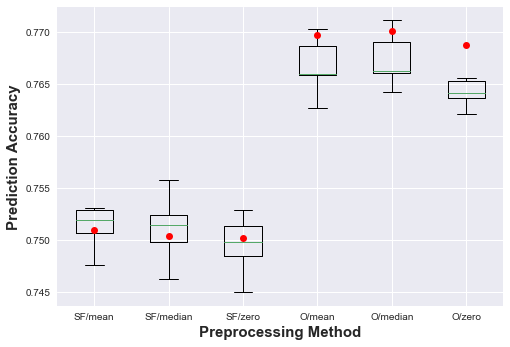

In [55]:
# Create boxplots
print(len(boxplots_preprocessing))
plt.style.use('seaborn')
plt.boxplot(boxplots_preprocessing, labels=['SF/mean', 'SF/median','SF/zero','O/mean','O/median', 'O/zero'])
plt.xlabel('Preprocessing Method', weight='bold', fontsize=15)
plt.ylabel('Prediction Accuracy', weight='bold', fontsize=15)
plt.plot(1, test_accuracies_preprocessing[0], marker='o', c='red')
plt.plot(2, test_accuracies_preprocessing[1], marker='o', c='red')
plt.plot(3, test_accuracies_preprocessing[2], marker='o', c='red')
plt.plot(4, test_accuracies_preprocessing[3], marker='o', c='red')
plt.plot(5, test_accuracies_preprocessing[4], marker='o', c='red')
plt.plot(6, test_accuracies_preprocessing[5], marker='o', c='red')
plt.savefig('Preprocessing.png')